In [1]:
import torch
import numpy as np
import pandas as pd
import random
# from models_A import preprocessing_from_matlab
from scipy.io.matlab import loadmat
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
from models_A import ModelA, ModelAN
from seaborn import set_theme

plt.style.use("duarte.mplstyle")
%matplotlib widget

In [2]:
states_mat = loadmat("../../../../xs_all_noise.mat")
forces_mat = loadmat("../../../../tau_all_noise.mat")

In [3]:
random_force_denorm = forces_mat["tau_all"][0][950].T
pd.DataFrame(random_force_denorm).tail(3)

,0,1,2,3
19998,21.584105,-0.00005,0.000037,-8.414414e-07
19999,21.584105,-0.00005,0.000010,-8.402745e-07
20000,21.584105,-0.00005,0.000039,-8.390432e-07


In [4]:
def preprocessing_from_matlab(data, n=0):
    key = list(data.keys())[-1]
    all_data = data[key].squeeze()
    all_data_normalized = []
    all_data_norms = []

    for data in all_data:
        data_normalized, data_norms = normalize(X=data.T[n:],
                                                axis=0,
                                                return_norm=True)
        data_norms
        all_data_normalized.append(data_normalized)
        all_data_norms.append(data_norms)

    return all_data_normalized, all_data_norms

In [5]:
states, states_norms = preprocessing_from_matlab(states_mat, n=500)
forces, forces_norms = preprocessing_from_matlab(forces_mat, n=500)

In [6]:
len(states), len(forces)

(1000, 1000)

In [7]:
states_df = pd.DataFrame(states[random.randrange(0,1000)]).round(6)
forces_df = pd.DataFrame(forces[random.randrange(0,1000)]).round(6)
display(states_df.tail())
display(forces_df.tail())

,0,1,2,3,4,5,6,7,8,9,10,11
19496,-0.009137,0.004646,0.0,0.001410,0.003470,-0.0,0.004678,0.009036,0.007303,0.008419,-0.003678,0.000001
19497,-0.009142,0.004637,0.0,0.001407,0.003472,-0.0,0.004669,0.009041,0.007303,0.008423,-0.003671,0.000001
19498,-0.009147,0.004628,0.0,0.001405,0.003475,-0.0,0.004660,0.009046,0.007303,0.008428,-0.003664,0.000001
19499,-0.009151,0.004619,0.0,0.001402,0.003476,-0.0,0.004650,0.009050,0.007303,0.008432,-0.003657,0.000001
19500,-0.009156,0.004611,0.0,0.001399,0.003478,-0.0,0.004641,0.009055,0.007303,0.008437,-0.003649,0.000001


,0,1,2,3
19496,0.007183,-0.000353,0.000700,-0.000001
19497,0.007183,-0.000343,0.000544,-0.000001
19498,0.007183,-0.000331,0.000271,-0.000001
19499,0.007183,-0.000342,0.000176,-0.000001
19500,0.007183,-0.000334,0.000283,-0.000001


In [8]:
random_state, random_state_norm = states[950], states_norms[950]
random_force, random_force_norm = forces[950], forces_norms[950]

In [9]:
display(pd.DataFrame(random_state).round(5).head())
display(pd.DataFrame(random_force).round(5).head())

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.01020,0.01166,0.04214,0.06097,-0.06128,0.08561,0.00282,0.00246,0.00211,-0.01576,-0.00968,-0.04004
1,0.01019,0.01168,0.04214,0.06108,-0.06109,0.08556,0.00283,0.00247,0.00211,-0.01557,-0.00981,-0.03910
2,0.01018,0.01169,0.04214,0.06118,-0.06090,0.08550,0.00284,0.00248,0.00212,-0.01538,-0.00993,-0.03815
3,0.01016,0.01171,0.04214,0.06128,-0.06070,0.08543,0.00285,0.00249,0.00213,-0.01518,-0.01006,-0.03721
4,0.01015,0.01173,0.04213,0.06138,-0.06051,0.08536,0.00286,0.00250,0.00213,-0.01499,-0.01018,-0.03627


,0,1,2,3
0,0.00715,0.01853,0.05401,-0.00564
1,0.00715,0.01802,0.05375,-0.00647
2,0.00715,0.01748,0.05397,-0.00730
3,0.00715,0.01695,0.05384,-0.00812
4,0.00715,0.01643,0.05385,-0.00894


In [10]:
model = ModelA()
model.load_state_dict(torch.load("model.pt"))
model_norms = ModelAN()
model_norms.load_state_dict(torch.load("model_norms.pt"))

<All keys matched successfully>

In [11]:
model.eval()
with torch.inference_mode():
    normalized_forces = model(torch.tensor(random_state, dtype=torch.float32))

In [12]:
model_norms.eval()
with torch.inference_mode():
    forces_norms = model_norms(torch.tensor(random_state_norm, dtype=torch.float32))

In [13]:
forces = []
for i in range(normalized_forces.shape[-1]):
    force_denorm = normalized_forces[:,i]*forces_norms[i]
    force_denorm = force_denorm.numpy()
    forces.append(force_denorm)
forces = np.array(forces).T

In [14]:
lenght = len(random_force_denorm[:,0][500:])
lenght

19501

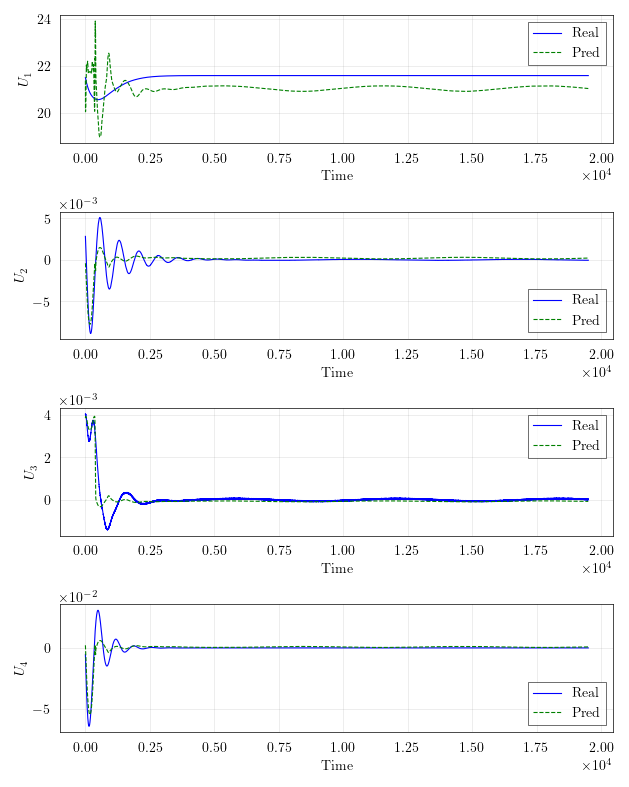

In [16]:
t = np.arange(0,lenght,1)

cm=1/2.54
fig, axs = plt.subplots(4,1, figsize=(16*cm,20*cm))
for i, ax in enumerate(axs.flatten()):
    # if i == 2:
    #     x1, x2, y1, y2 = 0, 2000, -0.01, 0.02  # subregion of the original image
    #     axins = ax.inset_axes([0.25, 0.25, 0.6, 0.6],xlim=(x1, x2), ylim=(y1,y2), xticklabels=[], yticklabels=[])
    #     axins.plot(t, forces[:,i])
    #     axins.plot(t, random_force_denorm[:,i][500:])
    #     ax.indicate_inset_zoom(axins, edgecolor="black")
    # ax.set_xlim(-100,5000)
    ax.plot(t, random_force_denorm[:,i][500:], label="Real")
    ax.plot(t, forces[:,i], label="Pred")
    ax.set_xlabel("Time")
    ax.set_ylabel(f"$U_{i+1}$")
    # ax.ticklabel_format(style="sci",
    #                     scilimits=(0,0),
    #                     useMathText=True,
    #                     axis="x")
    ax.legend()

fig.tight_layout()
fig.savefig("../../../report/figures/4results/uav/forces_denormalized.pdf", backend="pgf")